In [1]:
%matplotlib inline
from pylab import *

import shutil
import sys
import os.path
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import minimize
import itertools
import pyomo.environ as env
import ast
from pyomo.environ import *

import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
from pyvis import network as net

import watertap as wt

In [3]:
#### CAPABILITY LIST ####

#### WATER TREATMENT MMODEL DESIGN CAPABILITIES ####
# create a single unit process model
# create a single unit process model with a recovery stream
# create a single unit process with multiple source streams
# create a single unit process with multiple use streams
# add another unit process in parralel
# remove a unit process
# filter from a range of unit process to create a system/optimization problem
# TO DO: SAVE TREATMENT TRAIN. LOAD TREATMENT TRAIN --> ANNA.

# MODELING AND ANALYSES CAPABILITIES #
# simulate a single unit process (optimize if equations were given).
# simulat a single unit process model with a recovery stream (max recovery amount specified by user)
# optimize and select between multiple unit processes for single unit train
    # optimize above accounting for recyling streams, multiple sources, multiple uses
    
### NEED TO MAKE SURE NAMING OF LINKS IS NOT REPETITIVE for multiple source and end nodes --> DONE
### runs for multiple sources, ends and recycle ---> DONE
### add process in series
    ### add all components and run -> DONE
### add recycle to second process in train -> DONE
### optimization for single process -> DONE
### optimization for processes in series -> DONE


#### capability to do:
# ADD STREAM!!!! ---> DONE
# UNIT PROCESS AND UNIT PROCESS NAME SHOULD BE DIFFERENT --> DONE
# ALLOW TO ADD A UP BEFORE --> DONE

In [4]:
# TO DO LIST:
#1. LOAD AND SAVE TREATMENT TRAIN -> DONE
#2. @ UPs IN SERIES -> DONE

In [5]:
#### MODEL FUNCTIONS ####

In [6]:
# LINKS COMING OUT OF SOURCE NODE AND GOING INTO FIRST UP MUST EQUAL FEEDWATER TOTAL! 
def source_flow_constraint(m, source_node, variable, G): #RENAME THIS CONSTRAINT  
    
    link_variable = wt.get_model_chars.get_link_variable(m, variable)
    
    sum_of_inflows = 0
    for link in G.out_edges(source_node):
        sum_of_inflows = sum_of_inflows + link_variable[G.edges[link]['name']]

    max_flow_in = G.nodes[source_node][variable]
        
    return sum_of_inflows == max_flow_in

In [7]:
# SOURCE FLOW MASS BALANCE
def node_mass_balance_constraint(m, node, variable, G):
    
    link_variable = wt.get_model_chars.get_link_variable(m, variable)
    
    flow_in = 0
    for edge in G.in_edges(node):
        flow_in = flow_in + link_variable[G.edges[edge]['name']]
    flow_out = 0
    for edge in G.out_edges(node):
        flow_out = flow_out + link_variable[G.edges[edge]['name']]

    return (-0.000000001, flow_in - flow_out, 0.000000001)

In [8]:
#### GET EQUATION FOR OUTFLOWS OF UNIT PROCESS ####
def get_up_treatment_equation(m, unit_process, up_edge, variable, G):
    
    up = wt.get_up_module(G, up_edge)
    link_variable = wt.get_model_chars.get_link_variable(m, variable)
    
    link_variable_wname = link_variable[G.edges[up_edge]['name']]
    
    if variable == 'Flow':
        return up.flow_treatment_equation(m, G, link_variable_wname)
    if variable == 'TOC':
        return up.toc_treatment_equation(m, G, link_variable_wname)
    if variable == 'Nitrate':
        return up.nitrate_treatment_equation(m, G, link_variable_wname)
    if variable == 'TDS':
        return up.tds_treatment_equation(m, G, link_variable_wname, up_edge)

In [9]:
# NEW WITH UNIT PROCESS #
# recovered stream from unit process
def calculate_recovered_streams(m, unit_process, variable, G):
    
    sum_of_treated_flow = get_sum_of_up_outflow(m, unit_process, 'use_stream', variable, G)
    
    start_node = ('%s_start' % unit_process)
    end_node = ('%s_end' % unit_process)
    up_edge = (start_node, end_node)
    
    treated_flow = get_up_treatment_equation(m, unit_process, up_edge, variable, G)

    return sum_of_treated_flow == treated_flow
                                            

In [10]:
def get_sum_of_up_outflow(m, unit_process, link_type, variable, G):
    
    link_variable = wt.get_model_chars.get_link_variable(m, variable)
    
    sum_of_outflow = 0
    for edge in G.out_edges(('%s_end' % unit_process)):
        if G.edges[edge]['type'] == link_type:
            sum_of_outflow = sum_of_outflow + link_variable[G.edges[edge]['name']]
    
    return sum_of_outflow

In [11]:
# DO THIS NEXT ---> THIS IS ONLY RECYCLING FRACTION OF WASTE --> NEED TO ADD RECYCLE OF TREATED STREAM.
def max_recycle_streams(m, unit_process, variable, G):
        
    sum_of_recycle_flow = get_sum_of_up_outflow(m, unit_process, 'recycle_stream', variable, G)
    link_variable = wt.get_model_chars.get_link_variable(m, variable)
    
    start_node = ('%s_start' % unit_process)
    end_node = ('%s_end' % unit_process)
    up_edge = (start_node, end_node)
    up = wt.get_up_module(G, up_edge)
    
    if sum_of_recycle_flow is 0:
        return Constraint.Skip
    else:
        
        recycle_factor = G.edges[up_edge]['recycle_factor']
        
        sum_of_feedwater = 0

        for edge in G.in_edges('%s_source_and_recycle' % unit_process):
            if G.edges[edge]['type'] == 'feedwater_stream':
                sum_of_feedwater = sum_of_feedwater + link_variable[G.edges[edge]['name']]

        print('RECYCLE FACTOR:', recycle_factor)
        
        if variable == 'Flow':
            return sum_of_recycle_flow == sum_of_feedwater * recycle_factor
        else:
            if variable == 'TOC':
                treated_flow = up.toc_treatment_equation(m, G, sum_of_feedwater)
            if variable == 'Nitrate':
                treated_flow = up.nitrate_treatment_equation(m, G, sum_of_feedwater) 
            if variable == 'TDS':
                treated_flow = up.tds_treatment_equation(m, G, sum_of_feedwater) 
            return sum_of_recycle_flow == treated_flow * recycle_factor

In [12]:
#THIS IS FOR END NODE!!!!! BETTER NAMING NEEDED FOR FUNCTIONS ---> PROBABLY DON'T NEED THIS -> JUST OPTIMIZE FOR USE STREAMS!
def calculate_recovered_water(m, end_node, G): # AT NODE
    
    print(end_node)
    
    recovered_flow = 0; 
    for up_outflow_link in G.in_edges(end_node): # TO DO MAKE FUNCTION
        recovered_flow = recovered_flow + m.FlowInLinkSegments[G.edges[up_outflow_link]['name']]
    
    return model.RecoveredFlow[end_node] == recovered_flow

In [13]:
#THIS IS FOR END NODE!!!!! BETTER NAMING NEEDED FOR FUNCTIONS ---> PROBABLY DON'T NEED THIS -> JUST OPTIMIZE FOR USE STREAMS!
def calculate_total_train_cost(m, end_node, G): # AT NODE
    
    print(end_node)
    
    total_cost_at_use = 0
    
    for unit_process in wt.get_graph_chars.get_unit_process_name_list(T):

        up_start_node = ('%s_start' % unit_process)
        up_end_node = ('%s_end' % unit_process)
        up_edge = (up_start_node, up_end_node)

        up_cost = m.TotalCostInLinkSegments[G.edges[up_edge]['name']]

        total_cost_at_use = total_cost_at_use + up_cost

    return model.RecoveredCost[end_node] == total_cost_at_use


In [14]:
def calculate_levelized_cost(m, end_node):
    return model.LevelizedCost[end_node] == model.RecoveredCost[end_node] / model.RecoveredFlow[end_node]

In [15]:
# NEW WITH UNIT PROCESS #
# recovered stream from unit process # CHANGE UNIT PROCESS TO UNIT PROCESS NAME
def calculate_up_total_costs(m, unit_process, G, cost_method):
    
    print(unit_process)
    
    start_node = ('%s_start' % unit_process)
    end_node = ('%s_end' % unit_process)
    up_edge = (start_node, end_node)
    
    up = wt.get_up_module(G, up_edge)
    
    flow_in = m.FlowInLinkSegments[G.edges[up_edge]['name']]
    
    mem_manu = G.edges[up_edge]['mem_manu']
    mem_model_type = G.edges[up_edge]['mem_model_type']
    
    if mem_manu is not None:
        return m.TotalCostInLinkSegments[G.edges[up_edge]['name']] == up.total_up_cost(m=m, flow_in = flow_in, G = G,
                                                                                       cost_method = cost_method,
                                                                                      mem_manu = mem_manu,
                                                                                      mem_model_type = mem_model_type,
                                                                                      up_edge = up_edge)
    
    else:
        return m.TotalCostInLinkSegments[G.edges[up_edge]['name']] == up.total_up_cost(flow_in = flow_in, G = G,
                                                                               cost_method = cost_method)
      

In [16]:
##### BUILD OPTIMIZATION MODEL #####

In [17]:
def build_model(G, model, cost_method = 'wt', optimize_path = False):
        
    # SETS
    model.LinkSet = env.Set(initialize=wt.get_graph_chars.get_link_list(G)) # all links in network
    model.UnitProcesses = env.Set(initialize=wt.get_graph_chars.get_unit_process_name_list(G)) # all unit processes
    model.SourceNodes = env.Set(initialize=wt.get_graph_chars.get_source_nodes(G)) # all source nodes
    model.AllNoneSourceEndNodes = env.Set(initialize=wt.get_graph_chars.get_all_none_source_end_nodes(G))
    model.RecoveredWaterNodes = env.Set(initialize=wt.get_graph_chars.get_recovered_water_nodes(G))
        
    # VARIABLES
    model.FlowInLinkSegments = env.Var(model.LinkSet, bounds=(1e-20,None), initialize=1e-20)
    model.TOCInLinkSegments = env.Var(model.LinkSet, bounds=(1e-20,None), initialize=1e-20)
    model.NitrateInLinkSegments = env.Var(model.LinkSet, bounds=(1e-20,None), initialize=1e-20)
    model.RecoveredFlow = env.Var(model.RecoveredWaterNodes, bounds=(1e-20,None), initialize=1e-20)
    model.RecoveredCost = env.Var(model.RecoveredWaterNodes, bounds=(1e-20,None), initialize=1e-20)
    model.TotalCostInLinkSegments = env.Var(model.LinkSet, bounds=(1e-20,None), initialize=1e-20)
    model.TDSInLinkSegments = env.Var(model.LinkSet, bounds=(1e-20,None), initialize=1e-20)

    # END NODE FLOW - > FOR OPTIMIZATION LIKELY NOT NEEDEDW
    x1 = []
    
    if len(wt.get_graph_chars.get_recovered_water_nodes(G)) > 1:
        for i in range(0, len(wt.get_graph_chars.get_recovered_water_nodes(G))):
            x1.append([wt.get_graph_chars.get_recovered_water_nodes(G)[i], G])
    else:
        x1 = wt.get_graph_chars.get_recovered_water_nodes(G)
        x1.append(G)
        x1 = [x1]
    
    model.RecoveredWaterNodes2 = env.Set(initialize=x1) # all recovered water
    model.CalculateRecoveredWater = env.Constraint(model.RecoveredWaterNodes2, rule=calculate_recovered_water)
    
    model.CalculateRecoveredCost = env.Constraint(model.RecoveredWaterNodes2, rule=calculate_total_train_cost)    
    
    ##############################

    water_variables = ['Flow' , 'TOC', 'Nitrate'] #, 'TDS']
    x1 = []; x2 = []; x3 = [];
    for variable in water_variables:
        for i in range(0, len(wt.get_graph_chars.get_all_none_source_end_nodes(G))):
            x1.append([wt.get_graph_chars.get_all_none_source_end_nodes(G)[i], variable, G])
            
        for i in range(0, len(wt.get_graph_chars.get_source_nodes(G))):
            x2.append([wt.get_graph_chars.get_source_nodes(G)[i],  variable, G])            
            
        for i in range(0, len(wt.get_graph_chars.get_unit_process_name_list(T))):
            x3.append([wt.get_graph_chars.get_unit_process_name_list(G)[i], variable, G])     
    
    model.AllNoneSourceEndNodes2 = env.Set(initialize=x1)
    model.SourceNodes2 = env.Set(initialize=x2)
    model.UnitProcesses2 = env.Set(initialize=x3)

    # CONSTRAINTS FOR FLOW
    model.NodeMassBalanceConstraint = env.Constraint(model.AllNoneSourceEndNodes2, rule=node_mass_balance_constraint)
    model.CheckUnitInletFlows = env.Constraint(model.SourceNodes2, rule=source_flow_constraint)
    model.CalculateRecoveredFlows = env.Constraint(model.UnitProcesses2, rule=calculate_recovered_streams)

    # RECYCLE
    model.CalculateRecycleRecoveredFlows1 = env.Constraint(model.UnitProcesses2, rule=max_recycle_streams)  
    
    ## NEW CONSTRAINTS -> COST
    
    x1 = []
    
    if len(wt.get_graph_chars.get_unit_process_name_list(G)) > 1:
        for i in range(0, len(wt.get_graph_chars.get_unit_process_name_list(G))):
            x1.append([wt.get_graph_chars.get_unit_process_name_list(G)[i], G, cost_method])
    else:
        x1 = wt.get_graph_chars.get_unit_process_name_list(G)
        x1.append(G)
        x1.append(cost_method)
        x1 = [x1]
    
    print(x1)
    
    model.UnitProcesses3 = env.Set(initialize=x1)
    model.CalculateUPCosts = env.Constraint(model.UnitProcesses3,  rule=calculate_up_total_costs)
       
    # OPTIMIZATION FOR LEV COST
    model.LevelizedCost = env.Var(model.RecoveredWaterNodes, bounds=(1e-20,None), initialize=1e-20)
    model.CalculateLevelizedCost = env.Constraint(model.RecoveredWaterNodes,  rule=calculate_levelized_cost)
    
    ##### IF OPTIMIZING FOR PATHWAY #####
    
    y1 = sum(model.RecoveredCost[x] for x in model.RecoveredWaterNodes)
    y2 = sum(model.RecoveredFlow[x] for x in model.RecoveredWaterNodes)
    y3 = sum(model.LevelizedCost[x] for x in model.RecoveredWaterNodes)
    
    model.objective_function = env.Objective(expr= y1, sense=env.minimize)
        
    return model

In [18]:
#### BUILD TREATMENT TRAIN ####

In [10]:
unit_process_name_list = wt.unit_process_library_list

In [11]:
unit_process_name_list

['chlorination_twb',
 'media_filtration_twb',
 'microfiltration_twb',
 'ultrafiltration_twb',
 'nanofiltration_twb',
 'ro_twb',
 'uv_twb',
 'ro_bor',
 'uvozone_twb',
 'mbr']

In [21]:
#### SAVE TRAIN ####
path = 'Tutorial3_optimization_treatment_train_bor_example.csv'
#T = wt.save_train(T, path)
T = wt.load_train(path)

In [22]:
df = pd.read_csv('membrane_options.csv'); df = df.dropna()

adding unit process to network: mbr
adding unit process attributes: mbr


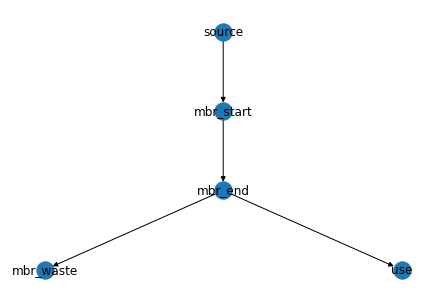

In [31]:
# imports all trains from library/unit processes
unit_process_name_list = [wt.unit_process_library_list[-1]] #[wt.unit_process_library_list[0], wt.unit_process_library_list[1]] 
#wt.unit_process_library_list

# FROM AND TO PROCESS TO BE CHANED TO SINGLE VS TRAIN OPTION - HAVE TWO OPTIONS. START WITH TRAIN.
T = wt.treatment_train_design.create_train(unit_process_name_list=['mbr'],  # OLDER VERSION HAD TO AND FROM PROCESS BUT THAT IS FOR ADDING ONE PROCESS AT A TIME
                                            #unit_process = 'microfiltration',
                                            source_water_reference = 'Poseidon',
                                            source_water_type = 'Wastewater',
                                            source_water_case_study ='Typical untreated domestic wastewater',
                                            enduse_water_reference = 'Poseidon',
                                            enduse_water_type = 'Environmental',
                                            enduse_water_case_study = 'EPA: Environmental Reuse',#,
                                            mem_manu = 'FilmTec',
                                            mem_model_type = 'BW30-400',
                                            flow = 0) #113562.0) #1000.0)

wt.display.treatment_train_graph(T)

In [81]:
##### ADD UNIT PROCESS IN SERIES #### (OR PARA?)
T = wt.treatment_train_design.add_unit_process(T, from_node = 'use',
                                                to_node = None, 
                                                unit_process_name_list = ['nanofiltration_twb'],
                                                unit_process_list = ['nanofiltration_twb'],
                                                adjust_end_use = True,
                                                adjust_source = True,
                                                order = 'series')


adding unit process to network: nanofiltration_twb
adding unit process attributes: ultrafiltration_twb
adding unit process attributes: nanofiltration_twb


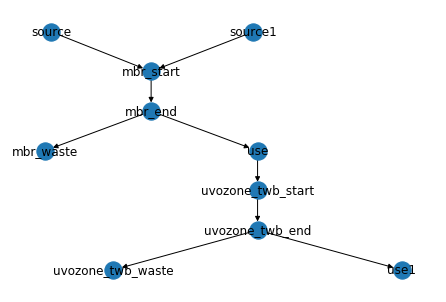

In [27]:
wt.display.treatment_train_graph(T)

In [32]:
##### ADD UNIT PROCESS IN SERIES #### (OR PARA?)
T = wt.treatment_train_design.add_unit_process(T, from_node = 'use',
                                                to_node = None, 
                                                unit_process_name_list = ['uvozone_twb'],
                                                unit_process_list = ['uvozone_twb'],
                                                adjust_end_use = True,
                                                adjust_source = True,
                                                order = 'series')


adding unit process to network: uvozone_twb
adding unit process attributes: mbr
adding unit process attributes: uvozone_twb


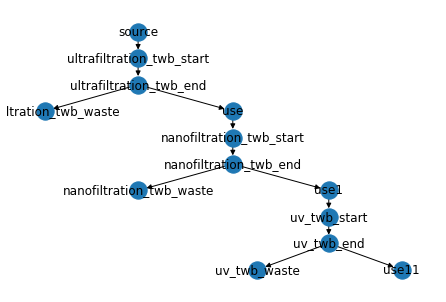

In [84]:
wt.display.treatment_train_graph(T)

In [85]:
path = 'twb_trains/twb_uf_nf_uv.csv'
wt.save_train(T, path)

In [86]:
ls twb_trains

twb_mf_nf_cl2.csv  twb_mf_ro_cl2.csv  twb_uf_nf_cl2.csv  twb_uf_ro_cl2.csv
twb_mf_nf_uv.csv   twb_mf_ro_uv.csv   twb_uf_nf_uv.csv   twb_uf_ro_uv.csv


In [36]:
T.nodes['source']['Flow'] = 45000

In [71]:
mapping = {'use1':'ro_to_chlorination' for new_label, old_label in enumerate(T.nodes())}
T = nx.relabel_nodes(T, mapping)

In [25]:
T = wt.filter_processes.remove_single_process(T, process_name = 'ro_bor')

adding another water source: source1


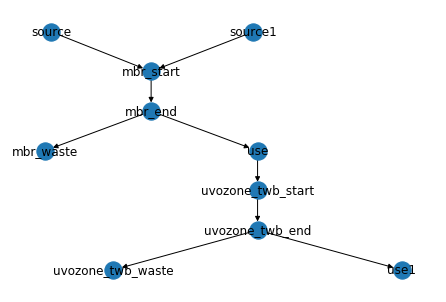

In [33]:
# ADD ANOTHER SOURCE 
source_to_node_names = [['source1', 'mbr_start']]
T = wt.treatment_train_design.add_multiple_water_sources(T,
                                              number_of_additional_sources = 1,
                                              source_water_reference = 'Poseidon',
                                              source_water_type = 'Wastewater',
                                              source_water_case_study = 'Typical untreated domestic wastewater',
                                              source_to_node_names=source_to_node_names,
                                              flow = 0)

wt.display.treatment_train_graph(T)

adding another water use: use_2


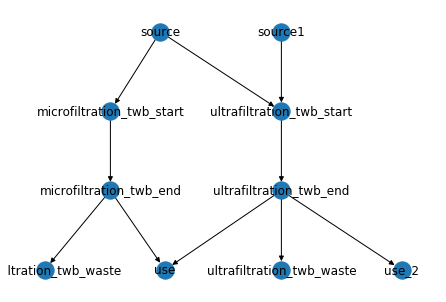

In [59]:
# ADD ANOTHER END USE 
node_to_use_names = [[('%s_end' % wt.unit_process_library_list[4]), 'use_2']]
T = wt.treatment_train_design.add_multiple_water_enduses(T,
                                              number_of_additional_ends = 1,
                                              enduse_water_reference = 'Poseidon',
                                              enduse_water_type = 'Wastewater',
                                              enduse_water_case_study = 'Typical untreated domestic wastewater',
                                              node_to_end_names= node_to_use_names,
                                              min_flow = 0)
wt.display.treatment_train_graph(T)

In [95]:
#recycle flow fraction could be defined from part of waste stream or based on UP chars (UP chars for now)
# how to apply to multiple streams?
#wt.treatment_train_design.
# ----> THE SOURCE STREAM NEEDS TO BE DEFINED -> WHICH STREAM RECYCLED FLOW GOES TO. IN MODEL. NEEDS TO BE CHECKED.
# ----> DOES NOT OPTIMIZE CORRECTLY FOR MULTIPLE SOURCE NODES
T = wt.treatment_train_design.add_recycle_stream(T,
                       unit_process = 'microfiltration_twb',
                       unit_process_name = 'microfiltration_twb',
                       recyle_fraction_of_waste = 1,
                       number_of_affected_streams = 1)

updating unit process attributes: microfiltration_twb
goes into adding unit attributes 2
edge ('microfiltration_twb_start', 'microfiltration_twb_end')


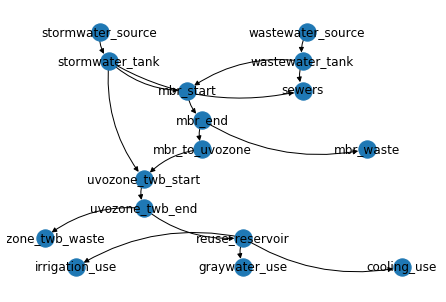

In [73]:
wt.display.treatment_train_graph(T, with_recycle = True)

In [68]:
#mapping = {'source1':'stormwater_tank' for new_label, old_label in enumerate(T.nodes())}
#T = nx.relabel_nodes(T, mapping)
mapping = {'source':'wastewater_tank' for new_label, old_label in enumerate(T.nodes())}
T = nx.relabel_nodes(T, mapping)    
#mapping = {'use':'mbr_to_uvozone' for new_label, old_label in enumerate(T.nodes())}
#T = nx.relabel_nodes(T, mapping)    
#mapping = {'use1':'reuse_reservoir' for new_label, old_label in enumerate(T.nodes())}
#T = nx.relabel_nodes(T, mapping)    
#wt.save_train(T, path)  

In [74]:
wt.save_train(T, 'baseline_trains/battery_park_city.csv')

In [60]:
T = wt.load_train('baseline_trains/battery_park_city.csv')

In [72]:
### ADD STREAM OF CHOICE TO WHAT SHOULD BE ANYWHERE ###
T = wt.treatment_train_design.add_stream(T, from_node = 'stormwater_source', 
                                    to_node = 'stormwater_tank',
                                    stream_name = 'source_to_storage',
                                    stream_type = 'source_stream')

In [75]:
T.nodes['source']['Flow'] = 0

In [76]:
model = env.ConcreteModel()
M = build_model(T, model, cost_method = 'twb', optimize_path = False) # SIMUL

use1
use1
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1a24a939b0>, 'twb'], ['chlorination_twb', <networkx.classes.digraph.DiGraph object at 0x1a24a939b0>, 'twb'], ['microfiltration_twb', <networkx.classes.digraph.DiGraph object at 0x1a24a939b0>, 'twb']]
ro_bor
Membrane: Koch_Fluid Systems --- TFC-SR2 8" (8723 SR2-400)
chlorination_twb
microfiltration_twb


/Users/amiara/miniconda3/envs/water-hubv2/lib/python3.7/site-packages/ipykernel_launcher.py:85: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/Users/amiara/miniconda3/envs/water-hubv2/lib/python3.7/site-packages/ipykernel_launcher.py:86: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/Users/amiara/miniconda3/envs/water-hubv2/lib/python3.7/site-packages/ipykernel_launcher.py:87: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


In [77]:
solver = env.SolverFactory("ipopt")
results = solver.solve(M)

In [78]:
analysis_variables = ['Flow', 'TOC' , 'Nitrate', 'Cost', 'TDS']
result_table = wt.post_processing.get_result_table(model, analysis_variables)
result_table[result_table.Flow > 0 ]

,Flow,TOC,Nitrate,Cost,TDS
ro_bor_feedwater,5700.0,140.0,0.0,0.000,0.0
ro_bor,5700.0,140.0,0.0,7.664,0.0
ro_bor_waste_stream,855.0,0.0,0.0,0.000,0.0
ro_bor_use_stream,4845.0,140.0,0.0,0.000,0.0
chlorination_twb_feedwater,4845.0,140.0,0.0,0.000,0.0
chlorination_twb,4845.0,140.0,0.0,4.483,0.0
chlorination_twb_use_stream,4845.0,140.0,0.0,0.000,0.0
microfiltration_twb_feedwater,6000.0,140.0,0.0,0.000,0.0
microfiltration_twb,6000.0,140.0,0.0,3.963,0.0
microfiltration_twb_waste_stream,300.0,0.0,0.0,0.000,0.0


In [40]:
result_table[result_table.Flow > 0 ]

,Flow,TOC,Nitrate,Cost,TDS
ro_bor7_feedwater,45000.0,20.0,0.0,0.000,0.0
ro_bor7,45000.0,20.0,0.0,6.479,0.0
ro_bor7_waste_stream,6750.0,0.0,0.0,0.000,0.0
ro_bor7_use_stream,38250.0,20.0,0.0,0.000,0.0


In [9]:
toc_list = []
flow_list = []
cost_list = []
tds_list = []
train_list = []

In [4]:
T = wt.load_train(path)

In [3]:
path = 'twb_trains/twb_mf_nf_uv.csv'

In [82]:
directory_name = 'bor_trains'
directory = os.fsencode(directory_name)
for file in os.listdir(directory):    
    filename = os.fsdecode(file)
    path = ('%s/%s' % (directory_name, filename))
    T = wt.load_train(path)
    
        ##### ADD UNIT PROCESS IN SERIES #### (OR PARA?)
    #T = wt.treatment_train_design.add_unit_process(T, from_node = 'use',
    #                                                to_node = None, 
    #                                                unit_process_name_list = ['chlorination_twb'],
    #                                                unit_process_list = ['chlorination_twb'],
    #                                                adjust_end_use = True,
    #                                                adjust_source = True,
    #                                                order = 'series')
    
    ##### ADD UNIT PROCESS IN SERIES #### (OR PARA?)
    #T = wt.treatment_train_design.add_unit_process(T, from_node = None,
    #                                                to_node = 'source', 
    #                                                unit_process_name_list = ['microfiltration_twb'],
    #                                                unit_process_list = ['microfiltration_twb'],
    #                                                adjust_end_use = True,
    #                                                adjust_source = True,
    #                                                order = 'series')
    
    mapping = {'source':'micro_to_ro' for new_label, old_label in enumerate(T.nodes())}
    T = nx.relabel_nodes(T, mapping)
    mapping = {'source1':'source' for new_label, old_label in enumerate(T.nodes())}
    T = nx.relabel_nodes(T, mapping)    
    mapping = {'use':'ro_to_chlorination' for new_label, old_label in enumerate(T.nodes())}
    T = nx.relabel_nodes(T, mapping)    
    mapping = {'use1':'use' for new_label, old_label in enumerate(T.nodes())}
    T = nx.relabel_nodes(T, mapping)    
    wt.save_train(T, path)    

In [86]:
path = 'Tutorial3_optimization_treatment_train_bor_example.csv'
T = wt.load_train(path)
    
##### ADD UNIT PROCESS IN SERIES #### (OR PARA?)
T = wt.treatment_train_design.add_unit_process(T, from_node = 'use',
                                                to_node = None, 
                                                unit_process_name_list = ['chlorination_twb'],
                                                unit_process_list = ['chlorination_twb'],
                                                adjust_end_use = True,
                                                adjust_source = True,
                                                order = 'series')

##### ADD UNIT PROCESS IN SERIES #### (OR PARA?)
T = wt.treatment_train_design.add_unit_process(T, from_node = None,
                                                to_node = 'source', 
                                                unit_process_name_list = ['microfiltration_twb'],
                                                unit_process_list = ['microfiltration_twb'],
                                                adjust_end_use = True,
                                                adjust_source = True,
                                                order = 'series')

mapping = {'source':'micro_to_ro' for new_label, old_label in enumerate(T.nodes())}
T = nx.relabel_nodes(T, mapping)
mapping = {'source1':'source' for new_label, old_label in enumerate(T.nodes())}
T = nx.relabel_nodes(T, mapping)    
mapping = {'use':'ro_to_chlorination' for new_label, old_label in enumerate(T.nodes())}
T = nx.relabel_nodes(T, mapping)    
mapping = {'use1':'use' for new_label, old_label in enumerate(T.nodes())}
T = nx.relabel_nodes(T, mapping)    
wt.save_train(T, path)    

adding unit process to network: chlorination_twb
adding unit process attributes: ro_bor
adding unit process attributes: ro_bor
adding unit process attributes: ro_bor
adding unit process attributes: ro_bor
adding unit process attributes: ro_bor
adding unit process attributes: ro_bor
adding unit process attributes: ro_bor
adding unit process attributes: chlorination_twb
adding unit process to network: microfiltration_twb
adding unit process attributes: ro_bor
adding unit process attributes: ro_bor
adding unit process attributes: ro_bor
adding unit process attributes: ro_bor
adding unit process attributes: ro_bor
adding unit process attributes: ro_bor
adding unit process attributes: ro_bor
adding unit process attributes: chlorination_twb
adding unit process attributes: microfiltration_twb


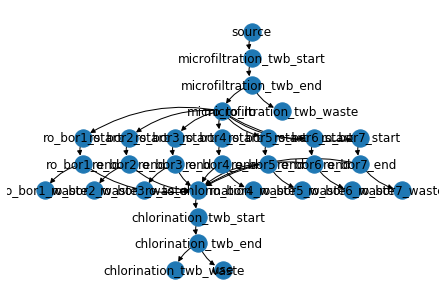

In [87]:
wt.display.treatment_train_graph(T, with_recycle = True)

In [62]:
##### ADD UNIT PROCESS IN SERIES #### (OR PARA?)
T = wt.treatment_train_design.add_unit_process(T, from_node = 'use',
                                                to_node = None, 
                                                unit_process_name_list = ['chlorination_twb'],
                                                unit_process_list = ['chlorination_twb'],
                                                adjust_end_use = True,
                                                adjust_source = True,
                                                order = 'series')


adding unit process to network: chlorination_twb
adding unit process attributes: ro_bor
adding unit process attributes: chlorination_twb


In [64]:
##### ADD UNIT PROCESS IN SERIES #### (OR PARA?)
T = wt.treatment_train_design.add_unit_process(T, from_node = None,
                                                to_node = 'source', 
                                                unit_process_name_list = ['microfiltration_twb'],
                                                unit_process_list = ['microfiltration_twb'],
                                                adjust_end_use = True,
                                                adjust_source = True,
                                                order = 'series')

adding unit process to network: microfiltration_twb
adding unit process attributes: ro_bor
adding unit process attributes: chlorination_twb
adding unit process attributes: microfiltration_twb


In [10]:
directory_name = 'twb_trains'
directory = os.fsencode(directory_name)
n = 0
for file in os.listdir(directory):
    if n > 0: break
    
    filename = os.fsdecode(file)
    path = ('%s/%s' % (directory_name, filename))
    T = wt.load_train(path)
    print(filename)
    for flow_v in range(6000, 40000, 500):
        
        T.nodes['source']['Flow'] = flow_v
        M = wt.build_model(T, cost_method = 'twb', optimize_path = False)
        wt.run_model(M)

        analysis_variables = ['Flow', 'TOC' , 'Nitrate', 'Cost', 'TDS']
        result_table = wt.post_processing.get_result_table(M, analysis_variables)

        cost_list.append(result_table.Cost.sum())
        flow_list.append(flow_v)        
        toc_list.append(result_table.TOC.min())
        train_list.append(filename)
    n = n + 1

twb_mf_nf_cl2.csv


In [11]:
df_result = pd.DataFrame()

In [12]:
df_result['flow_list'] = flow_list
df_result['toc_list'] = toc_list
df_result['cost_list'] = cost_list
df_result['train_list'] = train_list

In [13]:
df_result.to_csv('df_result_test2.csv')

In [14]:
result_table

,Flow,TOC,Nitrate,Cost,TDS
microfiltration_twb_feedwater,39500.0,140.0,0.0,0.000,0.0
microfiltration_twb,39500.0,140.0,0.0,26.087,0.0
microfiltration_twb_waste_stream,1975.0,0.0,0.0,0.000,0.0
microfiltration_twb_use_stream,37525.0,140.0,0.0,0.000,0.0
nanofiltration_twb_feedwater,37525.0,140.0,0.0,0.000,0.0
nanofiltration_twb,37525.0,140.0,0.0,37.174,0.0
nanofiltration_twb_waste_stream,7505.0,130.2,0.0,0.000,0.0
nanofiltration_twb_use_stream,30020.0,9.8,0.0,0.000,0.0
chlorination_twb_feedwater,30020.0,9.8,0.0,0.000,0.0
chlorination_twb,30020.0,9.8,0.0,7.099,0.0


In [44]:
mem_id = []
flow_list = []
cost_list = []
tds_list = []

In [64]:
for mem_manu in df.manufacturer.unique():
    for mem_model_type in df[df.manufacturer == mem_manu].model.unique():
        print('-------------')
        print(mem_manu)
        print(mem_model_type)
            
        for flow_v in range(500, 40000, 500):

            path = ('bor_%s_%s.csv' % (mem_manu, mem_model_type))
            T = wt.load_train(path)

            T.nodes['source']['Flow'] = flow_v

            model = env.ConcreteModel()
            M = build_model(T, model, cost_method = 'twb', optimize_path = False) # SIMUL

            solver = env.SolverFactory("ipopt")
            solver.solve(M)

            analysis_variables = ['Flow', 'TOC' , 'Nitrate', 'Cost', 'TDS']
            result_table = wt.post_processing.get_result_table(model, analysis_variables)

            cost_list.append(result_table.Cost.sum())
            mem_id.append(mem_model_type)
            flow_list.append(flow_v)
            # result_table[result_table.Flow > 0 ])

-------------
FilmTec
BW30-400
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1024778ba8>, 'twb']]
ro_bor
Membrane: FilmTec --- BW30-400


/Users/amiara/miniconda3/envs/water-hubv2/lib/python3.7/site-packages/ipykernel_launcher.py:85: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/Users/amiara/miniconda3/envs/water-hubv2/lib/python3.7/site-packages/ipykernel_launcher.py:86: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/Users/amiara/miniconda3/envs/water-hubv2/lib/python3.7/site-packages/ipykernel_launcher.py:87: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1023e1b198>, 'twb']]
ro_bor
Membrane: FilmTec --- BW30-400
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1024778ba8>, 'twb']]
ro_bor
Membrane: FilmTec --- BW30-400
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1022ed9898>, 'twb']]
ro_bor
Membrane: FilmTec --- BW30-400
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1023021dd8>, 'twb']]
ro_bor
Membrane: FilmTec --- BW30-400
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x10246837b8>, 'twb']]
ro_bor
Membrane: FilmTec --- BW30-400
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x10246aa668>, 'twb']]
ro_bor
Membrane: FilmTec --- BW30-400
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1022cf4828>, 'twb']]
ro_bor
Membrane: FilmTec --- BW30-400
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1022cf6208>, 'twb']]
ro_bor
Membrane: FilmTec --- BW30-400


use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1024121e10>, 'twb']]
ro_bor
Membrane: FilmTec --- BW30-400
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x10240362b0>, 'twb']]
ro_bor
Membrane: FilmTec --- BW30-400
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1024683748>, 'twb']]
ro_bor
Membrane: FilmTec --- BW30-400
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1023fc71d0>, 'twb']]
ro_bor
Membrane: FilmTec --- BW30-400
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1023f0cf60>, 'twb']]
ro_bor
Membrane: FilmTec --- BW30-400
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x102467bda0>, 'twb']]
ro_bor
Membrane: FilmTec --- BW30-400
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1022fe4080>, 'twb']]
ro_bor
Membrane: FilmTec --- BW30-400
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1022e5a048>, 'twb']]
ro_bor
Membrane: FilmTec --- BW30-400


use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x10243bcdd8>, 'twb']]
ro_bor
Membrane: FilmTec --- SW30-8040
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x10241db320>, 'twb']]
ro_bor
Membrane: FilmTec --- SW30-8040
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x10243bcf60>, 'twb']]
ro_bor
Membrane: FilmTec --- SW30-8040
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1024261358>, 'twb']]
ro_bor
Membrane: FilmTec --- SW30-8040
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1024121e10>, 'twb']]
ro_bor
Membrane: FilmTec --- SW30-8040
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1023efdac8>, 'twb']]
ro_bor
Membrane: FilmTec --- SW30-8040
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x10249f8400>, 'twb']]
ro_bor
Membrane: FilmTec --- SW30-8040
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1023011940>, 'twb']]
ro_bor
Membrane: FilmTec --- SW

use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1023d185f8>, 'twb']]
ro_bor
Membrane: Hydranautics --- 8040LHYCPA2
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x10245ac5f8>, 'twb']]
ro_bor
Membrane: Hydranautics --- 8040LHYCPA2
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1022dec4a8>, 'twb']]
ro_bor
Membrane: Hydranautics --- 8040LHYCPA2
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1023d187f0>, 'twb']]
ro_bor
Membrane: Hydranautics --- 8040LHYCPA2
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x10230e46d8>, 'twb']]
ro_bor
Membrane: Hydranautics --- 8040LHYCPA2
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x10246bd4e0>, 'twb']]
ro_bor
Membrane: Hydranautics --- 8040LHYCPA2
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1022cecd68>, 'twb']]
ro_bor
Membrane: Hydranautics --- 8040LHYCPA2
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x102

use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1023f53358>, 'twb']]
ro_bor
Membrane: Koch_Fluid Systems --- FS8822HR400 Prem
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x10247d2908>, 'twb']]
ro_bor
Membrane: Koch_Fluid Systems --- FS8822HR400 Prem
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1023c06710>, 'twb']]
ro_bor
Membrane: Koch_Fluid Systems --- FS8822HR400 Prem
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x102304dd30>, 'twb']]
ro_bor
Membrane: Koch_Fluid Systems --- FS8822HR400 Prem
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x102490a080>, 'twb']]
ro_bor
Membrane: Koch_Fluid Systems --- FS8822HR400 Prem
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1023c12470>, 'twb']]
ro_bor
Membrane: Koch_Fluid Systems --- FS8822HR400 Prem
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1023c87ba8>, 'twb']]
ro_bor
Membrane: Koch_Fluid Systems --- FS8822HR4

use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x10242004e0>, 'twb']]
ro_bor
Membrane: Koch_Fluid Systems --- FS8822HR400 Prem
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x10248f42b0>, 'twb']]
ro_bor
Membrane: Koch_Fluid Systems --- FS8822HR400 Prem
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1023028898>, 'twb']]
ro_bor
Membrane: Koch_Fluid Systems --- FS8822HR400 Prem
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x10246c6da0>, 'twb']]
ro_bor
Membrane: Koch_Fluid Systems --- FS8822HR400 Prem
-------------
Koch_Fluid Systems
TFC-S4 (4920 S)
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1023f50fd0>, 'twb']]
ro_bor
Membrane: Koch_Fluid Systems --- TFC-S4 (4920 S)
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x10246bd4e0>, 'twb']]
ro_bor
Membrane: Koch_Fluid Systems --- TFC-S4 (4920 S)
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x10240ae9e8>, 'twb']]
ro

use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x10241a7320>, 'twb']]
ro_bor
Membrane: Koch_Fluid Systems --- TFC-S4 (4920 S)
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1023c87ba8>, 'twb']]
ro_bor
Membrane: Koch_Fluid Systems --- TFC-S4 (4920 S)
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1022ff5a58>, 'twb']]
ro_bor
Membrane: Koch_Fluid Systems --- TFC-S4 (4920 S)
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1023c12e48>, 'twb']]
ro_bor
Membrane: Koch_Fluid Systems --- TFC-S4 (4920 S)
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1022dec588>, 'twb']]
ro_bor
Membrane: Koch_Fluid Systems --- TFC-S4 (4920 S)
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x10231123c8>, 'twb']]
ro_bor
Membrane: Koch_Fluid Systems --- TFC-S4 (4920 S)
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1023064550>, 'twb']]
ro_bor
Membrane: Koch_Fluid Systems --- TFC-S4 (4920 S)

use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1023e01278>, 'twb']]
ro_bor
Membrane: Koch_Fluid Systems --- TFC-SR2 8" (8723 SR2-400)
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1022e5ab70>, 'twb']]
ro_bor
Membrane: Koch_Fluid Systems --- TFC-SR2 8" (8723 SR2-400)
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x10243fcb70>, 'twb']]
ro_bor
Membrane: Koch_Fluid Systems --- TFC-SR2 8" (8723 SR2-400)
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1023c76f60>, 'twb']]
ro_bor
Membrane: Koch_Fluid Systems --- TFC-SR2 8" (8723 SR2-400)
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1023e1b2e8>, 'twb']]
ro_bor
Membrane: Koch_Fluid Systems --- TFC-SR2 8" (8723 SR2-400)
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1023e1b128>, 'twb']]
ro_bor
Membrane: Koch_Fluid Systems --- TFC-SR2 8" (8723 SR2-400)
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x102467bba8>, 'tw

use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1022ede5c0>, 'twb']]
ro_bor
Membrane: DuPont --- 6880T B-10 Twin
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1023ec61d0>, 'twb']]
ro_bor
Membrane: DuPont --- 6880T B-10 Twin
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1022f016a0>, 'twb']]
ro_bor
Membrane: DuPont --- 6880T B-10 Twin
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1023e01198>, 'twb']]
ro_bor
Membrane: DuPont --- 6880T B-10 Twin
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x10231120b8>, 'twb']]
ro_bor
Membrane: DuPont --- 6880T B-10 Twin
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1023028160>, 'twb']]
ro_bor
Membrane: DuPont --- 6880T B-10 Twin
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1023e2d390>, 'twb']]
ro_bor
Membrane: DuPont --- 6880T B-10 Twin
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1023e017f0>, 'twb

use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x10243fc668>, 'twb']]
ro_bor
Membrane: DuPont --- 6880T B-10 Twin
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1022f6b630>, 'twb']]
ro_bor
Membrane: DuPont --- 6880T B-10 Twin
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1022ff50b8>, 'twb']]
ro_bor
Membrane: DuPont --- 6880T B-10 Twin
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1023c87668>, 'twb']]
ro_bor
Membrane: DuPont --- 6880T B-10 Twin
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1022e8d9b0>, 'twb']]
ro_bor
Membrane: DuPont --- 6880T B-10 Twin
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1023e01588>, 'twb']]
ro_bor
Membrane: DuPont --- 6880T B-10 Twin
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x10241a7860>, 'twb']]
ro_bor
Membrane: DuPont --- 6880T B-10 Twin
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1024121cc0>, 'twb

In [65]:
df_result = pd.DataFrame()

In [66]:
df_result['flow_list'] = flow_list
df_result['mem_id'] = mem_id
df_result['cost_list'] = cost_list

In [68]:
df_result.to_csv('df_result_test.csv')

In [47]:
for flow_v in range(500, 400000, 10000):

    T.nodes['source']['Flow'] = flow_v

    model = env.ConcreteModel()
    M = build_model(T, model, cost_method = 'twb', optimize_path = False) # SIMUL

    solver = env.SolverFactory("ipopt")
    solver.solve(M)

    analysis_variables = ['Flow', 'TOC' , 'Nitrate', 'Cost', 'TDS']
    result_table = wt.post_processing.get_result_table(model, analysis_variables)
    
    cost_list.append(result_table.Cost.sum())
    flow_list.append(flow_v)

use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1a24a72160>, 'twb']]
ro_bor
Membrane: FilmTec --- BW30-400


/Users/amiara/miniconda3/envs/water-hubv2/lib/python3.7/site-packages/ipykernel_launcher.py:85: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/Users/amiara/miniconda3/envs/water-hubv2/lib/python3.7/site-packages/ipykernel_launcher.py:86: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/Users/amiara/miniconda3/envs/water-hubv2/lib/python3.7/site-packages/ipykernel_launcher.py:87: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1a24a72160>, 'twb']]
ro_bor
Membrane: FilmTec --- BW30-400
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1a24a72160>, 'twb']]
ro_bor
Membrane: FilmTec --- BW30-400
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1a24a72160>, 'twb']]
ro_bor
Membrane: FilmTec --- BW30-400
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1a24a72160>, 'twb']]
ro_bor
Membrane: FilmTec --- BW30-400
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1a24a72160>, 'twb']]
ro_bor
Membrane: FilmTec --- BW30-400
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1a24a72160>, 'twb']]
ro_bor
Membrane: FilmTec --- BW30-400
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1a24a72160>, 'twb']]
ro_bor
Membrane: FilmTec --- BW30-400
use
use
[['ro_bor', <networkx.classes.digraph.DiGraph object at 0x1a24a72160>, 'twb']]
ro_bor
Membrane: FilmTec --- BW30-400


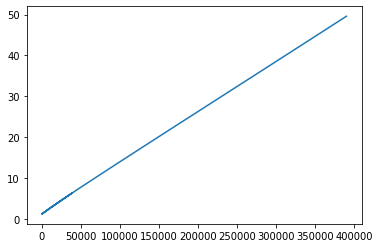

In [48]:
import matplotlib.pyplot as plt
import datetime
import numpy as np

x = cost_list
y = flow_list

plt.plot(y,x)
plt.show()

In [ ]:
for mem_manu in df.manufacturer.unique():
    for mem_model_type in df[df.manufacturer == mem_manu].model.unique():
    ##### ADD UNIT PROCESS IN SERIES #### (OR PARA?)
        T = wt.treatment_train_design.add_unit_process(T, from_node = 'source',
                                                        to_node = 'use', 
                                                        unit_process_name_list = [wt.unit_process_library_list[-1]],
                                                        unit_process_list = [wt.unit_process_library_list[-1]],
                                                        adjust_end_use = True,
                                                        adjust_source = True,
                                                        order = 'parallel', #,
                                                        mem_manu = mem_manu,
                                                        mem_model_type = mem_model_type)

In [ ]:
def get_membrane_details(mem_manu, mem_model_type):
        
    df = pd.read_csv('membrane_options.csv')
    a_list = []
    i = 0 

    df = df[((df.manufacturer == mem_manu) & (df.model == mem_model_type))]
    df = df.set_index(df.characteristic)
    for char_name in mem_char_list:

        a_list.append(df.loc[char_name].value)

        i = i + 1
    
    return a_list

In [42]:
df = pd.read_csv('membrane_options.csv'); df = df.dropna()

In [43]:
df.head()

,characteristic,unit,value,manufacturer,model,process_type,reference
0,mem_diameter,cm,20.32,FilmTec,BW30-400,RO,BOR_WaTER
1,mem_productivity,m3/day,40.00,FilmTec,BW30-400,RO,BOR_WaTER
2,mem_area_per_module,m2,37.00,FilmTec,BW30-400,RO,BOR_WaTER
3,mem_operating_pressure,kPa,1550.00,FilmTec,BW30-400,RO,BOR_WaTER
4,mem_TDS,mg/L,2000.00,FilmTec,BW30-400,RO,BOR_WaTER


In [5]:
from pyvis.network import Network
import pyvis
import networkx as nx

In [8]:
train_to_show = 'baseline_trains/battery_park_city.csv'
T = wt.load_train(train_to_show)

In [9]:
g = net.Network("500px", "100%", notebook = True, directed=True, heading='')
g.show_buttons()
g.from_nx(T)
#g.set_options("""
#""")
#g.show(str(train_to_show))
g.show('example.html')

In [7]:
show_train1(T)

In [3]:
def show_train1(G):
    from pyvis.network import Network
    import pyvis
    import networkx as nx
    
    g = net.Network("500px", "100%", notebook = True, directed=True, heading='')
    #g.show_buttons()
    g.from_nx(G)
    g.set_options("""
    var options = {
      "nodes": {
        "font": {
          "size": 38
        }
      },
      "edges": {
        "color": {
          "inherit": true
        },
        "smooth": {
          "type": "continuous",
          "forceDirection": "none"
        }
      },
      "layout": {
        "hierarchical": {
          "enabled": true,
          "levelSeparation": 400,
          "nodeSpacing": 50,
          "direction": "LR",
          "sortMethod": "directed"
        }
      },
      "interaction": {
        "navigationButtons": true
      },
      "physics": {
        "hierarchicalRepulsion": {
          "centralGravity": 0
        },
        "minVelocity": 0.75,
        "solver": "hierarchicalRepulsion"
      }
    }
        """)
    #g.show(str(train_to_show))
    return g.show('example.html')

In [ ]:
FOR THREE UNIT PROCESSES: 

In [4]:
def show_train(G):
    from pyvis.network import Network as net
    import pyvis
    import networkx as nx
    
    g = net.Network("500px", "100%", notebook = True, directed=True, heading='')
    #g.show_buttons()
    g.from_nx(G)
    g.set_options("""
    var options = {
      "nodes": {
        "borderWidth": 2,
        "font": {
          "background": "rgba(255,255,255,1)"
        },
        "physics": false
      },
      "edges": {
        "color": {
          "inherit": true
        },
        "physics": false,
        "selfReferenceSize": 38,
        "smooth": {
          "type": "continuous",
          "forceDirection": "none"
        },
        "width": 2
      },
      "layout": {
        "hierarchical": {
          "enabled": true,
          "nodeSpacing": 150,
          "treeSpacing": 20,
          "direction": "LR",
          "sortMethod": "directed"
        }
      },
      "interaction": {
        "navigationButtons": true
      },
      "physics": {
        "hierarchicalRepulsion": {
          "centralGravity": 1
        },
        "minVelocity": 0.75,
        "solver": "hierarchicalRepulsion"
      }
    }
    """)
    #g.show(str(train_to_show))
    return g.show('example.html')

In [50]:
g = net.Network("500px", "100%", notebook = True, directed = True, heading='') #directed=True
g.add_nodes(list(T.nodes()),
x=[5, 20, 10, 30, 40, 50, 60, 70, 80, 80, 90, 100, 100, 5, 15, 5],
y=[15, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 10, 5, 5, 15, 5],
label=list(T.nodes()))

g.add_edges(list(T.edges()))

g.show_buttons()

In [51]:
g.show("example.html")

In [14]:
T.nodes()

NodeView(('wastewater_tank', 'mbr_start', 'sewers', 'mbr_end', 'mbr_waste', 'mbr_to_uvozone', 'uvozone_twb_start', 'uvozone_twb_end', 'uvozone_twb_waste', 'reuse_reservoir', 'irrigation_use', 'graywater_use', 'cooling_use', 'stormwater_tank', 'wastewater_source', 'stormwater_source'))

In [60]:
g = Network(notebook=True, heading="")
g.add_nodes([1,2,3], value=[10]*3, x=[21.4, 54.2, 11.2], y=[100.2, 23.54, 32.1], label=["NODE 1", "NODE 2", "NODE 3"], color=["#00ff1e", "#162347", "#dd4b39"])
g.show('test1.html')

In [35]:
import chlorination_twb

In [77]:
dose = 12.5
flow_in = 3785.41178*20

In [78]:
chlorination_twb.get_chlorine_dose_cost(T, flow_in, dose)

R2 value of simple polynomial model: 0.9769796478096178
12.5


6824.4721926409275

In [56]:
import ml_regression

In [57]:
#def get_chlorine_dose_cost(G, flow_in, dose):
    
import pyomo.environ as env

dir_path = '/Users/amiara/NAWI/WaterTap/Python_UPlinks'
df = pd.read_csv('%s/chlorine_dose_cost_twb.csv' % dir_path) #import data
df.Flow_m3day = df.Flow_m3day /3785.41178 
flow_for_function = flow_in

max_flow = df.Flow_m3day.max()
y_value = 'Cost'
poly_ml, coeff_poly = ml_regression.make_simple_poly(df, y_value)    
print(dose)

f_array = []
f1 = dose
f2 = flow_for_function
f3 = dose ** 2
f4 = flow_for_function * dose
f5 = flow_for_function ** 2
f6 = dose ** 3
f7 = flow_for_function * dose ** 2
f8 = dose * flow_for_function ** 2
f9 = flow_for_function ** 3
f_array.append([f1, f2, f3, f4, f5, f6, f7, f8, f9])

cost_sum = 0 
i = 0 
for co_value in coeff_poly.Coefficients:
        cost_value = co_value * f_array[0][i]
        cost_sum = cost_sum + cost_value
        i = i + 1

#    return cost_sum

R2 value of simple polynomial model: 0.9769796478096178
10


In [58]:
f_array

[[10, 10, 100, 100, 100, 1000, 1000, 1000, 1000]]

In [60]:
cost_sum

7171.388483224651

In [43]:
df1=pd.DataFrame()

In [44]:
df1['dose']=[dose]*2
df1['flow_in']=[flow_in]*2

In [51]:
new_df = ml_regression.make_df_for_ml(df1)

In [52]:
poly_ml.predict(new_df)

array([-146.7572716, -146.7572716])

In [53]:
new_df

,Feature1,Feature2,Feature1^2,Feature1 Feature2,Feature2^2,Feature1^3,Feature1^2 Feature2,Feature1 Feature2^2,Feature2^3
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [31]:
cost_sum

-22952973526.229305

In [64]:
len(coeff_poly.Coefficients)

19

In [142]:
poly_ml.predict(new_df)

array([-2.20708721, -2.20708721])

In [158]:
coeff_poly.Coefficients.index

Index(['Feature1', 'Feature2', 'Feature1^2', 'Feature1 Feature2', 'Feature2^2',
       'Feature1^3', 'Feature1^2 Feature2', 'Feature1 Feature2^2',
       'Feature2^3'],
      dtype='object')

In [93]:
df1 = pd.DataFrame()
df1['dose'] = [dose] * 2
df1['feed_uvt'] = [feed_uvt] * 2
df1['flow_in'] = [flow_in] * 2

In [94]:
new_df = ml_regression.make_df_for_ml(df1)

In [95]:
new_df

,Feature1,Feature2,Feature3,Feature1^2,Feature1 Feature2,Feature1 Feature3,Feature2^2,Feature2 Feature3,Feature3^2,Feature1^3,Feature1^2 Feature2,Feature1^2 Feature3,Feature1 Feature2^2,Feature1 Feature2 Feature3,Feature1 Feature3^2,Feature2^3,Feature2^2 Feature3,Feature2 Feature3^2,Feature3^3
0,10.0,0.55,2.628757,100.0,5.5,26.28757,0.3025,1.445816,6.910363,1000.0,55.0,262.8757,3.025,14.458164,69.103634,0.166375,0.795199,3.8007,18.165666
1,10.0,0.55,2.628757,100.0,5.5,26.28757,0.3025,1.445816,6.910363,1000.0,55.0,262.8757,3.025,14.458164,69.103634,0.166375,0.795199,3.8007,18.165666


In [65]:
def make_simple_poly1(df, y_value):

    from sklearn.preprocessing import PolynomialFeatures

    df['y'] = df[y_value]
    del df[y_value]
    
    n = 0
    for c_name in df.columns:
        if c_name != 'y':
            n = n + 1
            df[('Feature%s' % n)] = df[c_name]
            del df[c_name]
            
            
    poly2 = PolynomialFeatures(3,include_bias=False)
    #X1=np.array(10*np.random.randn(37,3)) test
    df1 = df.copy(deep=True); del df1['y']; df1 = df1.T
    X = []
    for column_name in df1.columns:
        X.append(list(df1[column_name]))
        X2 = np.array(X)

    X_poly = poly2.fit_transform(X2)
    X_poly_feature_name = poly2.get_feature_names(['Feature'+str(l) for l in range(1,4)])

    df_poly = pd.DataFrame(X_poly, columns=X_poly_feature_name)    
    
    poly = PolynomialFeatures(3,include_bias=False)

    #X1=np.array(10*np.random.randn(37,3)) test
    df1 = df.copy(deep=True); del df1['y']; df1 = df1.T
    X = []
    for column_name in df1.columns:
        X.append(list(df1[column_name]))
        X2 = np.array(X)

    X_poly = poly.fit_transform(X2)
    X_poly_feature_name = poly.get_feature_names(['Feature'+str(l) for l in range(1,4)])

    df_poly = pd.DataFrame(X_poly, columns=X_poly_feature_name)
    df_poly['y']=df['y']

    X_train=df_poly.drop('y',axis=1)
    y_train=df_poly['y']

    poly = LinearRegression(normalize=True)

    model_poly=poly.fit(X_train,y_train)
    y_poly = poly.predict(X_train)
    RMSE_poly=np.sqrt(np.sum(np.square(y_poly-y_train)))
    #print("Root-mean-square error of simple polynomial model:",RMSE_poly)
    print ("R2 value of simple polynomial model:",model_poly.score(X_train,y_train))
    
    coeff_poly = pd.DataFrame(model_poly.coef_,index=df_poly.drop('y',axis=1).columns, 
                          columns=['Coefficients'])
    
    return poly, coeff_poly

In [69]:
#### LOAD AND SAVE TRAIN ####
path = 'TT_save_late.csv'
wt.save_train(T, path)
TT = wt.load_train(path)

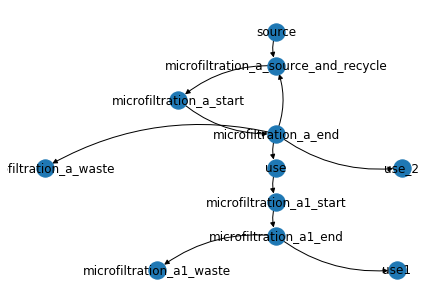

In [70]:
wt.display.treatment_train_graph(TT, with_recycle = True)

In [21]:
4732*24

113568

In [50]:
import ml_regression

In [23]:
flow_in = 4732*24

In [24]:
import ml_regression

initial_chlorine_demand = 3.0 #mg/L ;;;; cl2_dem = get_cl2_dem(G, unit_process) # mg/L 
contact_time = 1.5 #hours
contact_time_mins = 1.5 * 60
ct = 450 # mg/L-min ---> ASSUME CALI STANDARD FOR NOW
chlorine_decay_rate = 3.0 # mg/Lh

applied_cl2_dose = initial_chlorine_demand + chlorine_decay_rate*contact_time + ct/contact_time_mins # mg/L

#chlorine_dose_cost = get_chlorine_dose_cost(flow, applied_cl2_dose) / 1000 #$MM

# TO DO:
#Chlorine Consumption
#Trace Organic Chemicals (TOrC)
#Estradiol Equivalency (EEQ)
#Giardia lamblia
#Total Coliforms (including fecal coliform and E. Coli)
#Viruses (enteric)


In [42]:
dose = applied_cl2_dose

In [43]:
dose = 0
flow_in = 0

In [44]:
def get_chlorine_dose_cost(flow_in, dose):
    
    dir_path = '/Users/amiara/NAWI/WaterTap/Python_UPlinks'
    df = pd.read_csv('%s/chlorine_dose_cost_twb.csv' % dir_path) #import data

    max_flow = df.Flow_m3day.max()
    cost_value1 = 0
    flow_list = []
    y_value = 'Cost'
    poly_ml = ml_regression.make_simple_poly(df, y_value)    

    hold_flow_frac = int(flow_in/max_flow)

    flow_list = [max_flow]

    df1 = pd.DataFrame()
    df1['Dose'] = [dose] * len(flow_list)
    df1['Flow'] = flow_list    

    df_for_ml = ml_regression.make_df_for_ml(df1)
    cost_value1 = cost_value1 + poly_ml.predict(df_for_ml).sum() * hold_flow_frac


    flow_list = []
    flow_list = [max_flow * ((flow_in/max_flow) - int(flow_in/max_flow))]


    df1 = pd.DataFrame()
    df1['Dose'] = [dose] * len(flow_list)
    df1['Flow'] = flow_list    

    df_for_ml = ml_regression.make_df_for_ml(df1)
    cost_value1 = cost_value1 + poly_ml.predict(df_for_ml).sum() * hold_flow_frac     

    
    return cost_value1

In [45]:
cost_value1 = get_chlorine_dose_cost(flow_in, dose)

R2 value of simple polynomial model: 0.9769796478096178


AttributeError: 'tuple' object has no attribute 'predict'

In [46]:
cost_value1

NameError: name 'cost_value1' is not defined

In [47]:
def make_df_for_ml(df1):
            
    poly2 = PolynomialFeatures(3,include_bias=False)
    #X1=np.array(10*np.random.randn(37,3)) test
    df1 = df1.copy(deep=True); df1 = df1.T
    X = []
    for column_name in df1.columns:
        X.append(list(df1[column_name]))
        X2 = np.array(X)
    
    
    X_poly = poly2.fit_transform(X2)
    X_poly_feature_name = poly2.get_feature_names(['Feature'+str(l) for l in range(1,4)])

    df_poly = pd.DataFrame(X_poly, columns=X_poly_feature_name)

    return df_poly

In [48]:
#  def make_simple_poly(df, y_value):

from sklearn.preprocessing import PolynomialFeatures

df['y'] = df[y_value]
del df[y_value]

n = 0
for c_name in df.columns:
    if c_name != 'y':
        n = n + 1
        df[('Feature%s' % n)] = df[c_name]
        del df[c_name]


poly2 = PolynomialFeatures(3,include_bias=False)
#X1=np.array(10*np.random.randn(37,3)) test
df1 = df.copy(deep=True); del df1['y']; df1 = df1.T
X = []
for column_name in df1.columns:
    X.append(list(df1[column_name]))
    X2 = np.array(X)

X_poly = poly2.fit_transform(X2)
X_poly_feature_name = poly2.get_feature_names(['Feature'+str(l) for l in range(1,4)])

df_poly = pd.DataFrame(X_poly, columns=X_poly_feature_name)    

poly = PolynomialFeatures(3,include_bias=False)

#X1=np.array(10*np.random.randn(37,3)) test
df1 = df.copy(deep=True); del df1['y']; df1 = df1.T
X = []
for column_name in df1.columns:
    X.append(list(df1[column_name]))
    X2 = np.array(X)

X_poly = poly.fit_transform(X2)
X_poly_feature_name = poly.get_feature_names(['Feature'+str(l) for l in range(1,4)])

df_poly = pd.DataFrame(X_poly, columns=X_poly_feature_name)
df_poly['y']=df['y']

X_train=df_poly.drop('y',axis=1)
y_train=df_poly['y']

poly = LinearRegression(normalize=True)

model_poly=poly.fit(X_train,y_train)
y_poly = poly.predict(X_train)
RMSE_poly=np.sqrt(np.sum(np.square(y_poly-y_train)))
#print("Root-mean-square error of simple polynomial model:",RMSE_poly)
print ("R2 value of simple polynomial model:",model_poly.score(X_train,y_train))
    
#    return poly
    

NameError: name 'LinearRegression' is not defined

In [49]:
coeff_poly = pd.DataFrame(model_poly.coef_,index=df_poly.drop('y',axis=1).columns, 
                          columns=['Coefficients'])

NameError: name 'model_poly' is not defined

In [50]:
coeff_poly

NameError: name 'coeff_poly' is not defined

In [58]:
dose = 12.5

In [63]:
flow_in = 4732*24 * 0.8

In [67]:
#def get_chlorine_dose_cost2(flow_in, dose):
    
import pyomo.environ as env

dir_path = '/Users/amiara/NAWI/WaterTap/Python_UPlinks'
df = pd.read_csv('%s/chlorine_dose_cost_twb.csv' % dir_path) #import data

flow_for_function = env.value(flow_in)

max_flow = df.Flow_m3day.max()
cost_value1 = 0
flow_list = []
y_value = 'Cost'
poly_ml, coeff_poly = ml_regression.make_simple_poly(df, y_value)    

f_array = []
f1 = dose
f2 = flow_in
f3 = dose ** 2
f4 = flow_in * dose
f5 = flow_in ** 2
f6 = dose ** 3
f7 = flow_in * dose ** 2
f8 = dose * flow_in ** 2
f9 = flow_in ** 3
f_array.append([f1, f2, f3, f4, f5, f6, f7, f8, f9])

cost_sum = 0 
co_values = []
i = 0 

for co_value in coeff_poly.Coefficients:
        cost_value = co_value * f_array[0][i]
        cost_sum = cost_sum + cost_value
        i = i + 1
    
#    return cost_sum

R2 value of simple polynomial model: 0.9769796478096178


In [68]:
cost_value1 = get_chlorine_dose_cost2(flow_in, dose)

R2 value of simple polynomial model: 0.9769796478096178


In [69]:
cost_value1

8200.496225142771

In [70]:
264.172

264.172

In [57]:
flow_in

113568

In [40]:
dir_path = '/Users/amiara/NAWI/WaterTap/Python_UPlinks'
df = pd.read_csv('%s/chlorine_dose_cost_twb.csv' % dir_path) #import data

In [41]:
y_value = 'Cost'
#poly_ml = ml_regression.make_simple_poly(df, y_value)

In [29]:
df.head()

,y,Feature1,Feature2
0,600,1,3785.41178
1,1400,5,3785.41178
2,2000,10,3785.41178
3,2200,15,3785.41178
4,4000,25,3785.41178


In [37]:
x = 0.7

In [38]:
int(x) * 5

0

In [27]:
import numpy as np
#import wntr
import matplotlib.pyplot as plt
import itertools
import pandas as pd
#import pyomo.environ as env
import ast
from ast import literal_eval
import datetime
import time
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn import datasets
from sklearn.linear_model import LassoCV
from sklearn import ensemble



import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

In [ ]:
poly_ml.predict(df_for_ml).sum()

In [38]:
#OTHER FEATURES IN PROGRESS - SENSITIVITY ANALYSIS

for recyle_fraction_of_waste in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:

    unit_process_name_list = wt.unit_process_library_list
    T = wt.treatment_train_design.create_train(unit_process_name_list=unit_process_name_list,  # OLDER VERSION HAD TO AND FROM PROCESS BUT THAT IS FOR ADDING ONE PROCESS AT A TIME
                                                source_water_reference = 'Poseidon',
                                                source_water_type = 'Wastewater',
                                                source_water_case_study ='Typical untreated domestic wastewater',
                                                enduse_water_reference = 'Poseidon',
                                                enduse_water_type = 'Environmental',
                                                enduse_water_case_study = 'EPA: Environmental Reuse',
                                                flow = 1000.0)

    T = wt.treatment_train_design.add_recycle_stream(T,
                           from_unit_process = 'microfiltration_a',
                           to_unit_process = 'microfiltration_a',
                           recyle_fraction_of_waste = recyle_fraction_of_waste,
                           number_of_affected_streams = 1) #
    
    
    model = env.ConcreteModel()
    M = build_model(T, model)
    solver = env.SolverFactory("ipopt")
    result = solver.solve(M)
    
    print('RECYCLED AMOUNT:', recyle_fraction_of_waste)
    
    for x in model.LinkSet:
        if 'treated' in x:
            print(x, ':', round(env.value(model.FlowInLinkSegments[x]), 2))


adding unit process to network: microfiltration_a
adding unit process to network: ultrafiltration_a
adding unit process to network: uv_a
adding unit process attributes: microfiltration_a
adding unit process attributes: ultrafiltration_a
adding unit process attributes: uv_a
updating unit process attributes: microfiltration_a
recovery_stream
recovery_stream
recovery_stream


/Users/amiara/miniconda3/envs/water-hubv2/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


RECYCLED AMOUNT: 0.5
microfiltration_a_treated_stream : 0.0
ultrafiltration_a_treated_stream : 0.0
uv_a_treated_stream : 990.0
adding unit process to network: microfiltration_a
adding unit process to network: ultrafiltration_a
adding unit process to network: uv_a
adding unit process attributes: microfiltration_a
adding unit process attributes: ultrafiltration_a
adding unit process attributes: uv_a
updating unit process attributes: microfiltration_a
recovery_stream
recovery_stream
recovery_stream
RECYCLED AMOUNT: 0.6
microfiltration_a_treated_stream : 0.0
ultrafiltration_a_treated_stream : 0.0
uv_a_treated_stream : 990.0
adding unit process to network: microfiltration_a
adding unit process to network: ultrafiltration_a
adding unit process to network: uv_a
adding unit process attributes: microfiltration_a
adding unit process attributes: ultrafiltration_a
adding unit process attributes: uv_a
updating unit process attributes: microfiltration_a
recovery_stream
recovery_stream
recovery_strea

In [ ]:
##### OTHER FEATURES DONE #####

#!!!! FUNCTIONS FOR DESIGN CAPABILITIES!!!!
# REMOVE ONE OR PROCESSES IF NEEDED;;;; TO DO: ACTUALLY REMOVE THE NODES THAT ARE NOT CONNECTED So they don't
# show up when plotting.
#T = wt.filter_processes.remove(T, process_name = 'microfiltration_a')
#T = wt.filter_processes.select_single_processes(T, process_name = 'microfiltration_a')
#T = wt.filter_processes.select_multiple_processes(T, process_name_list = ['microfiltration_a', 'ultrafiltration_a'])


# IMPORT FEEDWATER DATA ----> NOT NEEDED ANYMORE TO RUN MODEL ----> BUT GOOD CAPABILITY TO HAVE
#fw_filename = 'case_study_water_sources_and_uses.csv'
#feedwater_data = wt.importfile.feedwater(input_file = fw_filename,
#                                         reference = 'Poseidon',
#                                         case_study = 'Typical untreated domestic wastewater',
#                                         water_type = 'Wastewater',
#                                         source_or_use = 'Source')

#feedwater_data